In [35]:
import os
import pandas as pd
import json
import io
import re
import string
import tensorflow as tf
import tqdm
import shutil
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px 


from tensorflow.keras import Model
from tensorflow.keras.layers import Dot, Embedding, Flatten

import warnings
warnings.filterwarnings('ignore')

In [37]:
embedd = pd.read_csv('./csv_files/embedding.csv')
embedd.head(2)

,Unnamed: 0,book_id,book_nb_comm,title,name,surname,tags,img_url,comm_id,user_id,...,filtre_sentiments,sentimentest,sentiments_final,com_final,commentaire_test,sentiments,commentaire_clean,commentaire_clean_lemma,commentaire_BERT,len_commentaire_clean
0,0,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,2080694,706958,...,"[furieux, plaisir]","['colère', 'joie']",colère joie,roadtrip désertique dans l' ouest américain en...,Roadtrip desertique dans Ouest Americain en co...,"['fou', 'furieux', 'plaisir', 'repos', 'repose...",Roadtrip desertique dans Ouest Americain en co...,roadtrip désertique dans louest Américain en c...,Roadtrip desertique dans Ouest Americain en co...,155
1,1,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,1271915,319761,...,"[humour, bonheur, plaisir, rire, angoisse, pla...","['joie', 'joie', 'joie', 'joie', 'peur', 'joie']",joie joie joie joie peur joie,de temps en temps j' aime bien revenir vers ...,De temps en temps aime bien revenir vers oeuvr...,"['angoisse', 'apre', 'bien', 'bonheur', 'doux'...",De temps en temps aime bien revenir vers oeuvr...,de temps en temps jaim bien revenir vers loeuv...,De temps en temps aime bien revenir vers oeuvr...,317


### Test Nan Values

In [38]:
def test_null_values(df, print_=False, clean_nan=False):
    df_ = df.copy()
    for i, col in enumerate(df_.select_dtypes('object')):
        df_[col] = df_[col].apply(lambda x:np.nan if x=='' else x)
    if print_:
        print(df_.isna().sum()) 
    index_ = df_[pd.isnull(df_).any(1)].index
    if clean_nan:
        mask_nan = df_.index.isin(index_)
        df_ = df_[~mask_nan]
        df_ = df_.reset_index().drop(['index'], axis=1)
    return df_

In [39]:
embedd = test_null_values(embedd, print_=True, clean_nan=True)

Unnamed: 0                   0
book_id                      0
book_nb_comm                 0
title                        0
name                         0
surname                      0
tags                         0
img_url                      0
comm_id                      0
user_id                      0
note                         0
date                         0
appreciations                0
commentaire                  0
com_process                  0
tokenized                    0
filtre_sentiments            0
sentimentest                 0
sentiments_final             0
com_final                    0
commentaire_test             0
sentiments                   0
commentaire_clean            0
commentaire_clean_lemma      0
commentaire_BERT           160
len_commentaire_clean        0
dtype: int64


In [41]:
embedd['sentiments']

0        ['fou', 'furieux', 'plaisir', 'repos', 'repose...
1        ['angoisse', 'apre', 'bien', 'bonheur', 'doux'...
2        ['bien', 'deçu', 'enerve', 'equilibre', 'fou',...
3        ['aimer', 'alarme', 'bien', 'dommage', 'doute'...
4        ['accord', 'affront', 'amitie', 'aval', 'beau'...
                               ...                        
45530    ['bien', 'coeur', 'entrain', 'foi', 'manque', ...
45531    ['bien', 'doute', 'passion', 'passionnant', 'b...
45532    ['douceur', 'plaisir', 'dou', 'douceur', 'plai...
45533    ['amical', 'amicale', 'apre', 'bien', 'coeur',...
45534    ['bien', 'coeur', 'curieux', 'deçu', 'douceur'...
Name: sentiments, Length: 45535, dtype: object

### Vectorization

In [42]:
def vectorization(df, col):
    df2 = df.copy()
    mask = df[col].apply(lambda x: type(x)==str)
    df = df.loc[mask,:]
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") 
    tokenizer.fit_on_texts(df[col])
    df["encoded"] = tokenizer.texts_to_sequences(df[col])
    reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(df["encoded"], padding="post")
    return df, reviews_pad, tokenizer

In [43]:
df, reviews_pad, tokenizer = vectorization(embedd, 'sentiments')

In [44]:
df["encoded"]

0        [17, 522, 11, 129, 322, 17, 522, 11, 129, 322, 9]
1        [109, 8, 2, 41, 225, 40, 108, 173, 100, 257, 1...
2        [2, 27, 359, 141, 17, 522, 11, 2, 27, 309, 141...
3        [52, 640, 2, 85, 15, 29, 4, 250, 91, 201, 256,...
4        [88, 97, 39, 164, 3, 2, 220, 172, 7, 78, 42, 3...
                               ...                        
45530    [2, 7, 40, 4, 59, 14, 43, 2, 7, 40, 4, 49, 14,...
45531                   [2, 15, 14, 43, 2, 13, 15, 14, 43]
45532                               [113, 11, 13, 113, 11]
45533    [351, 422, 8, 2, 7, 19, 73, 351, 422, 8, 2, 7,...
45534    [2, 7, 230, 27, 113, 12, 28, 98, 73, 2, 7, 230...
Name: encoded, Length: 45535, dtype: object

In [51]:
sentiments = df[['sentiments','encoded']]

### Preparation pour Word2Vec

In [49]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    # Des éléments de chaque exemple de training sont annexés à ces listes.
    targets, contexts, labels = [], [], []

    # Créez la table d'échantillonnage pour les tokens vocab_size.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Itérer sur toutes les séquences (phrases) du dataset et produire une barre de progression.
    for sequence in tqdm.tqdm(sequences):

        # Générer des paires de skip-gram positives pour une séquence (phrase).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
              sequence,
              vocabulary_size=vocab_size,
              sampling_table=sampling_table, # distribution de probabilité à partir de laquelle tirer
              window_size=window_size,
              negative_samples=0)

        # Itérer sur chaque paire positive de skip-gram pour produire des exemples de training 
        # avec un mot de contexte positif et des échantillons négatifs.
        for target_word, context_word in positive_skip_grams:
            
            # crée un tensor de shape (1,1)
            target_word = tf.expand_dims(tf.constant([target_word], dtype="int64"),1)
            
            # crée un tensor de shape (1, 1)
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            
            # crée les skip-grams negatifs
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                    true_classes=context_class,
                    num_true=1,
                    num_sampled=num_ns,
                    unique=True,
                    range_max=vocab_size,
                    seed=SEED,
                    name="negative_sampling")
        
            # Construire des vecteurs de contexte et de labels (pour un mot target)
            negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1) # shape (num_ns, 1)

            # shape du vecteur context (num_ns+1, 1)
            context = tf.concat([context_class, negative_sampling_candidates], 0)
            
            # crée le vecteur label
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Ajoutez chaque élément de l'exemple de training aux listes globales.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

In [50]:
SEED = 123

vocab_size = tokenizer.num_words
vocab_size

1000

In [52]:
targets, contexts, labels = generate_training_data(
      sequences=sentiments["encoded"],
      window_size=2,             # taille de la fenètre sur laquelle on fait les skipgrams
      num_ns=4,                  # nombre de samples négatifs 
      vocab_size=vocab_size,     # nombre de mots total (du vocabulaire)
      seed=SEED)

print(len(targets), len(contexts), len(labels))

100%|███████████████████████████████████████████████████████████████████████████| 45535/45535 [03:37<00:00, 209.63it/s]

217304 217304 217304


In [53]:
BATCH_SIZE = 32

# BUFFER_SIZE = 2401118 
BUFFER_SIZE = len(targets)

In [54]:
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))

In [55]:
import tempfile

# path = 'C:\\Users\\david\\AppData\\Local\\Temp'
path = os.path.join(tempfile.gettempdir(), "saved_data_embedded")

In [56]:
# Save le dataset
#dataset.save(path)
#tf.saved_model.save(model, '/tmp/adder')
tf.data.experimental.save(dataset, path)

In [57]:
# Load le dataset
new_dataset = tf.data.experimental.load(path)
new_dataset

<_LoadDataset element_spec=((TensorSpec(shape=(1, 1), dtype=tf.int64, name=None), TensorSpec(shape=(5, 1), dtype=tf.int64, name=None)), TensorSpec(shape=(5,), dtype=tf.int64, name=None))>

In [58]:
BATCH_SIZE = 32
BUFFER_SIZE = 2401118
new_dataset = new_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

print(new_dataset)

<BatchDataset element_spec=((TensorSpec(shape=(32, 1, 1), dtype=tf.int64, name=None), TensorSpec(shape=(32, 5, 1), dtype=tf.int64, name=None)), TensorSpec(shape=(32, 5), dtype=tf.int64, name=None))>


In [59]:
AUTOTUNE = tf.data.AUTOTUNE
dataset = new_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print(dataset)

<PrefetchDataset element_spec=((TensorSpec(shape=(32, 1, 1), dtype=tf.int64, name=None), TensorSpec(shape=(32, 5, 1), dtype=tf.int64, name=None)), TensorSpec(shape=(32, 5), dtype=tf.int64, name=None))>


In [60]:
# embedding_dim = 128
vocab_size = 1000
embedding_dim = 64

target_embedding = Embedding(vocab_size,
                            embedding_dim,
                            input_length=1,
                            name="w2v_embedding",
                             mask_zero=True)

context_embedding = Embedding(vocab_size,
                              embedding_dim,
                              input_length=4+1,
                              name="context_embedding")

dots = Dot(axes=3,name="dot_product")

flatten = Flatten()

In [61]:
# le target word vector est un tensor de shape (batch_size, 1, 1)
# c'est une séquence de 1 mot avec un canal de représentation
target = tf.keras.Input(shape=[1,1], name="target")

# le vecteur context a une shape (batch_size, 5, 1) 
# il contient 5 mots avec un canal de représentation
context = tf.keras.Input(shape=[5,1], name="context")

# la target est embedded
word_emb = target_embedding(target)

# le context est embedded
context_emb = context_embedding(context)

# on calcule le dot product pour les 2 embeddings
dots_result = dots([context_emb, word_emb])

# flatten le result
flat = flatten(dots_result)

# on applique la sigmoid pour comparer avec le binary label
output = tf.keras.activations.sigmoid(flat)
# output2 = tf.keras.activations.softmax(flat)

# depuis le model en utilisant les inputs et outputs
word2vec = tf.keras.Model(inputs=[target,context], outputs=output)

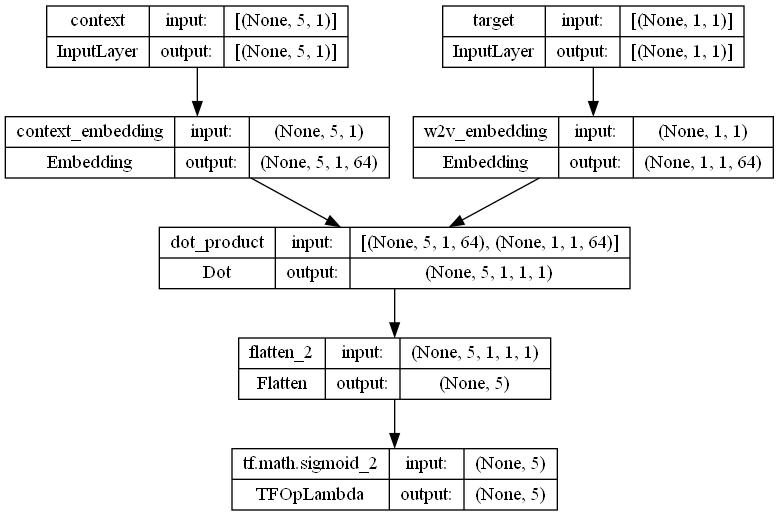

In [62]:
tf.keras.utils.plot_model(word2vec, show_shapes=True)

In [63]:
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

In [64]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [65]:
word2vec.fit(dataset, epochs=4, callbacks=[tensorboard_callback])

Epoch 1/4
6790/6790 [==============================] - 52s 6ms/step - loss: 0.4185 - accuracy: 0.5055
Epoch 2/4
6790/6790 [==============================] - 43s 6ms/step - loss: 0.3615 - accuracy: 0.6138
Epoch 3/4
6790/6790 [==============================] - 42s 6ms/step - loss: 0.3524 - accuracy: 0.6302
Epoch 4/4
6790/6790 [==============================] - 43s 6ms/step - loss: 0.3458 - accuracy: 0.6424


In [66]:
checkpoint_path = "./Saving_model/"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=4*batch_size)

In [67]:
# Lorsqu'on veut sauvegarder les poids du modèle
word2vec.save_weights(checkpoint_dir)

In [68]:
def create_model():
    
    embedding_dim = 64

    target_embedding = Embedding(vocab_size,
                            embedding_dim,
                            input_length=1,
                            name="w2v_embedding",
                             mask_zero=True)

    context_embedding = Embedding(vocab_size,
                              embedding_dim,
                              input_length=4+1,
                              name="context_embedding")

    dots = Dot(axes=3,name="dot_product")

    flatten = Flatten()
    
    target = tf.keras.Input(shape=[1,1], name="target")
    context = tf.keras.Input(shape=[5,1], name="context")
    word_emb = target_embedding(target)
    context_emb = context_embedding(context)
    dots_result = dots([context_emb, word_emb])
    flat = flatten(dots_result)
    output = tf.keras.activations.sigmoid(flat)    
    model = tf.keras.Model(inputs=[target,context], outputs=output)
    model.compile(optimizer='adam',
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])
    
    return model

In [69]:
model = create_model()

model.load_weights(checkpoint_dir)

In [ ]:
%load_ext tensorboard

%tensorboard --logdir logs

In [24]:
model.save("model_embedding.h5")
json.dump(model.history.history, open("/content/simpleRNN_history.json", 'w'))

In [71]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]

vocab = [value for value in tokenizer.index_word.values()][:1000]

In [72]:
vocab

['out_of_vocab',
 "'bien'",
 "'beau'",
 "'foi'",
 "'mal'",
 "'rien'",
 "'coeur'",
 "'apre'",
 "'rir'",
 "'rage'",
 "'plaisir'",
 "'interessant'",
 "'dou'",
 "'passion'",
 "'doute'",
 "'attachant'",
 "'fou'",
 "'profond'",
 "'relation'",
 "'surprise'",
 "'difficile'",
 "'prenant'",
 "'peur'",
 "'haine'",
 "'ouverture'",
 "'egal'",
 "'deçu'",
 "'magnifique'",
 "'drole'",
 "'etrange'",
 "'peine'",
 "'espoir'",
 "'amer'",
 "'choix'",
 "'violence'",
 "'rire'",
 "'triste'",
 "'interêt'",
 "'amitie'",
 "'entrain'",
 "'bonheur'",
 "'courage'",
 "'passionnant'",
 "'surpris'",
 "'malheur'",
 "'sentiment'",
 "'reflexion'",
 "'mauvais'",
 "'manqu'",
 "'deçue'",
 "'trac'",
 "'aimer'",
 "'rieur'",
 "'parfait'",
 "'regret'",
 "'touche'",
 "'charm'",
 "'fantastique'",
 "'manque'",
 "'mystere'",
 "'incroyable'",
 "'heureuse'",
 "'ravi'",
 "'qualite'",
 "'rare'",
 "'violent'",
 "'emouvant'",
 "'abandon'",
 "'avantage'",
 "'horreur'",
 "'desir'",
 "'venge'",
 "'tension'",
 "'joi'",
 "'difficulte'",
 "'bo

In [73]:
out_v = io.open('vectors_emotions.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata_emotions.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
    
out_v.close()
out_m.close()

https://projector.tensorflow.org/